# Function Approximation in RL : LSTD(lambda)

**Due date : 20/03/2018**

**By : Julien Roy and David Kanaa**

In [1]:
import time

import numpy as np
import pycolab

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

Least Squares Temporal Difference methods[2] (LSTD) allow to make better use of the training data than simpler TD learning methods at the cost of additional computation. However, in many setups, these additional computations are worth it as LSTD will converge faster overall than TD methods. The LSTD($\lambda$) algorithm from Boyan[1] adds eligibility traces to this process, allowing to choose the amount of bootstrapping to be used.

In this work, we implement two versions of this algorithm : an off-line version (complexity $O(n^3)$ in space) and a recursive version inspired by Bradtke and Barto [2] (complexity $O(n^2)$ in space). Those two algorithms are tested in two simple environments : the 13-states Boyan's Chain [1] and the 5-states Bradtke's Domain [2]. Finally, we empirically validate a proof made in Boyan's paper demonstrating that when $\lambda=1$, LSTD($\lambda$) is equivalent to supervised learning using a least squared error loss and sampled Monte-Carlo trajectories.

[1] : Bradtke, S. J., & Barto, A. G. (1996). Linear least-squares algorithms for temporal difference learning. Machine learning, 22(1-3), 33-57.

[2] : Boyan, J. A. (2002). Technical update: Least-squares temporal difference learning. Machine Learning, 49(2-3), 233-246.

# Implementations : Environments

### Simple function to display our environments (only used to test our environment implementations)

In [2]:
def show_board(obs, board_footprints=None, leave_footprints=False):
    
    # Represents the agent as a yellow dot on the board
    board = 100 * np.array(obs.layers['P'], dtype=np.float)
    
    # Indicates in which states the agent went
    if leave_footprints:
        new_footprints = 20 * np.array(obs.layers['P'], dtype=np.float)
    
        if board_footprints is not None:
            board_footprints += new_footprints
            board += board_footprints
        else:
            board_footprints = new_footprints
    
    # Adds the Goal as a green dot on the board (if there is one)
    if 'G' in obs.layers:
        board += 80 * np.array(obs.layers['G'], dtype=np.float)

    # Creates the figure
    plt.figure(figsize=5 * np.array(board.shape))
    plt.imshow(board)
    plt.axis('off')
    plt.show()
    
    return board_footprints

### Environment - Boyan's Chain

In [3]:
BOYAN_CHAIN = ['P           G']

boyan_features = np.array([
            [1.00, 0.00, 0.00, 0.00],
            [0.75, 0.25, 0.00, 0.00],
            [0.50, 0.50, 0.00, 0.00],
            [0.25, 0.75, 0.00, 0.00],
            [0.00, 1.00, 0.00, 0.00],
            [0.00, 0.75, 0.25, 0.00],
            [0.00, 0.50, 0.50, 0.00],
            [0.00, 0.25, 0.75, 0.00],
            [0.00, 0.00, 1.00, 0.00],
            [0.00, 0.00, 0.75, 0.25],
            [0.00, 0.00, 0.50, 0.50],
            [0.00, 0.00, 0.25, 0.75],
            [0.00, 0.00, 0.00, 0.00],
        ])

def make_BoyanChain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BoyanChain})

class PlayerSprite_BoyanChain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BoyanChain, self).__init__(corner, position, character, impassable='#')
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call
            
            # From the last state before the Goal
            if layers["G"][0, position + 1]:
                self._east(board, the_plot)   # single jump east
                the_plot.add_reward(-2.0)

            # From any other state 
            else:
                # Each one of the 2 possible transitions have a probability of 0.5
                if np.random.rand() > 0.5:    # single jump east
                    self._east(board, the_plot)
                else:                         # double jump east
                    self._east(board, the_plot)
                    self._east(board, the_plot)

                # Any transition from those states give a reward of -3
                the_plot.add_reward(-3.0)
                 
        # Check if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.terminate_episode()

###### Little test (demo) for Boyan's Chain

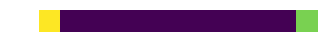

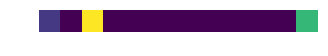

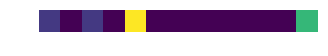

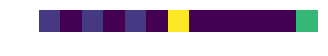

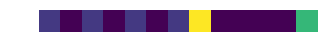

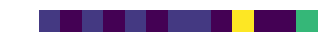

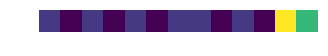

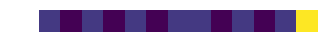

GAME OVER
Undiscounted Return : -20.0


In [4]:
undiscounted_return = 0

game = make_BoyanChain(BOYAN_CHAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)
while not(game.game_over):
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {}'.format(undiscounted_return))

### Environment - Bradtke's 5-states Domain

In [5]:
BRADTKE_DOMAIN = ['P    ']

bradtke_features = np.array([
    [74.29, 34.61, 73.48, 53.29,  7.79],
    [61.60, 48.07, 34.68, 36.19, 82.02],
    [97.00,  4.88,  8.51, 87.89,  5.17],
    [41.10, 40.13, 64.63, 92.67, 31.09],
    [ 7.76, 79.82, 43.78,  8.56, 61.11]
])

def make_BradtkeDomain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BradtkeDomain})

class PlayerSprite_BradtkeDomain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BradtkeDomain, self).__init__(corner, position, character, impassable='#')
        
        self.transition_matrix = np.array([
            [0.42, 0.13, 0.14, 0.03, 0.28],
            [0.25, 0.08, 0.16, 0.35, 0.15],
            [0.08, 0.20, 0.33, 0.17, 0.22],
            [0.36, 0.05, 0.00, 0.51, 0.07],
            [0.17, 0.24, 0.19, 0.18, 0.22]
        ])
        
        self.reward_matrix = np.array([
            [104.66, 29.69,  82.36,  37.49, 68.82],
            [ 75.86, 29.24, 100.37,   0.31, 35.99],
            [ 57.68, 65.66,  56.95, 100.44, 47.63],
            [ 96.23, 14.01,   0.88,  89.77, 66.77],
            [ 70.35, 23.69,  73.41,  70.70, 85.41]
        ])
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call

            # New position is sampled from a multinouilli distribution parametrized by the environment's transition matrix
            new_position = np.argmax(np.random.multinomial(n=1, pvals=self.transition_matrix[position, :]))
            
            # Receives a reward according to the reward matrix (deterministic reward associated with each transition)
            the_plot.add_reward(self.reward_matrix[position, new_position])
            
            # Move the agent to the new position
            self._teleport((0, new_position))

###### Little test (demo) for Bradtke's Domain

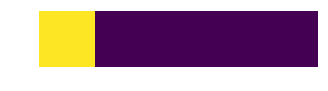

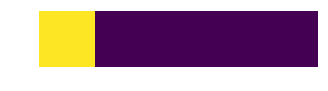

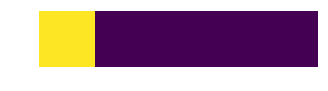

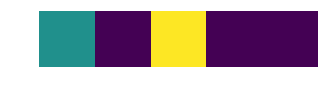

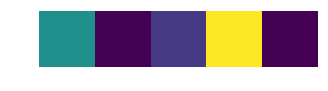

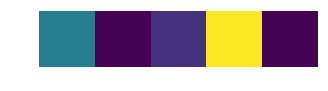

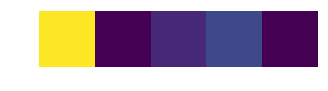

GAME OVER
Undiscounted Return : 578.12


In [7]:
undiscounted_return = 0

game = make_BradtkeDomain(BRADTKE_DOMAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)

while undiscounted_return < 500:
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {:.2f}'.format(undiscounted_return))

# Implementations : Algorithms

### Off-line LSTD($\lambda$)

In [8]:
def LSTD(game_initializer, features, gamma, lamda, n_trajectories, epsilon=1e-5, max_steps=10000, return_A_b=False):
    
    n_dims = features.shape[1]
    
    # Continuing task
    if return_A_b:
        betas = np.zeros(shape=(10000, n_dims))
    # Episodic task
    else:
        betas = np.zeros(shape=(n_trajectories, n_dims))
    
    # Initializes A, B and t
    A, b, t = epsilon * np.identity(n_dims), 0, 0
    
    for n in range(n_trajectories):
        
        # Reinitializes the environment
        game = game_initializer()
        
        # Chooses a start state x_t
        obs, _, _ = game.its_showtime()
        agent_mask = np.array(obs.layers['P'])
        state = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
        
        # Initializes the eligibility trace vector
        eligibility = features[state[1]]
        
        if return_A_b:
            A_s = []
            b_s = []
        
        while not game.game_over and t < 10000:
            # Simulate one step of the chain, producing a reward R_t and next state x_{t+1}
            obs, reward, _ = game.play(0)
            agent_mask = np.array(obs.layers['P'])
            next_state = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
            
            # Difference between features
            delta = features[state[1]] - (gamma * features[next_state[1]])
            
            # Updates A and b
            A = A + np.outer( eligibility, delta )
            b = b + (eligibility * reward)
            
            # Updates eligibility trace vector
            eligibility = (lamda * eligibility) + features[next_state[1]]
            
            t = t + 1
            state = next_state
                
            if return_A_b:
                A_s.append(A)
                b_s.append(b)
        
        # Updates parameters beta by inversing A
        if return_A_b:
            for t in range(10000):
                A_inverse = np.linalg.inv(A_s[t])
                betas[t] = np.squeeze(np.dot(A_inverse, b_s[t]))
        else:
            A_inverse = np.linalg.inv(A)
            betas[n] = np.squeeze(np.dot(A_inverse, b))
    
    return betas

### Recursive LSTD($\lambda$)

In [9]:
def rLSTD(game_initializer, features, gamma, lamda, n_trajectories, epsilon=1e5, max_steps=10000, return_A_b=False):
    
    n_dims = features.shape[1]
    # Continuing task
    if return_A_b:
        betas = np.zeros(shape=(10000, n_dims))
    # Episodic task
    else:
        betas = np.zeros(shape=(n_trajectories, n_dims))
    
    # Initializes A, B and t
    A, b, t = epsilon * np.identity(n_dims), 0, 0
    
    if return_A_b:
            A_s = []
            b_s = []
    
    for n in range(n_trajectories):
        
        # Reinitializes the environment
        game = game_initializer()
        
        # Chooses a start state x_t
        obs, _, _ = game.its_showtime()
        agent_mask = np.array(obs.layers['P'])
        state = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
        
        # Initializes the eligibility trace vector
        eligibility = np.expand_dims(features[state[1]], axis=1)
        
        while not game.game_over and t < max_steps:
            # Simulate one step of the chain, producing a reward R_t and next state x_{t+1}
            obs, reward, _ = game.play(0)
            agent_mask = np.array(obs.layers['P'])
            next_state = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
            
            # Difference between features
            delta = np.expand_dims(features[state[1]] - (gamma * features[next_state[1]]), axis=1)
            
            #
            v = np.dot(A.T, delta)
            A = A - ( np.dot(np.dot(A, eligibility), v.T) / (1 + np.dot(v.T, eligibility)) )
            b = b + (eligibility * reward)
            
            #
            eligibility = (lamda * eligibility) + np.expand_dims(features[next_state[1]], axis=1)
            state = next_state
        
            t = t + 1
            
            if return_A_b:
                A_s.append(A)
                b_s.append(b)
        
        
        if return_A_b:
            for t in range(10000):
                beta = np.dot(A_s[t], b_s[t])
                betas[t] = np.squeeze(beta)
        else:
            beta = np.dot(A, b)
            betas[n] = np.squeeze(beta)
        
    return betas

# Experiments

In [63]:
n_trials = 10
n_trajectories = 1000
lambdas = [1., 0.75, 0.50, 0.25, 0.]
markers = ["|", "^", "x", "v", "o"]
beta_star = np.array([-24., -16., -8., 0.])

### 1. Comparison between off-line and recursive LSTD($\lambda$) on Boyan's Chain

5it [00:37,  7.44s/it]
5it [00:39,  7.88s/it]


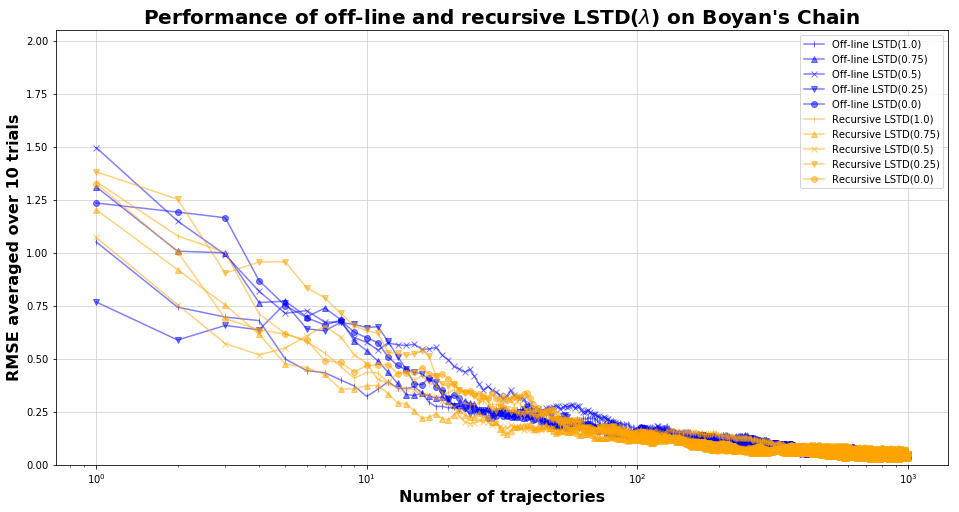

In [64]:
plt.figure(figsize=(16, 8))

# Run experiments for different lambda values for the off-line algorithm
for lamda, marker in tqdm(zip(lambdas, markers)):
    
    RMSE_offline = np.zeros(shape=(n_trials, n_trajectories))
    for trial in range(n_trials):
        
        # Run one experiment for n_trajectories
        betas_offline = LSTD(lambda : make_BoyanChain(BOYAN_CHAIN), boyan_features, 1., lamda, n_trajectories)
        
        # Computes RMS error of predicted values over all states compared to optimal values (computed with parameters beta_star)
        predicted_Vs = np.dot(betas_offline, boyan_features.T)
        optimal_V = np.dot(beta_star, boyan_features.T)
        
        # Takes the RMS error
        RMSE_offline[trial] = np.sqrt(np.mean((predicted_Vs - optimal_V)**2, axis=1))
    
    # Take average of RMSE over the 10 trials
    avg_RMSE_offline = np.mean(RMSE_offline, axis=0)
        
    # plot results
    plt.semilogx(avg_RMSE_offline, label="Off-line LSTD({})".format(lamda), color='blue', marker=marker, alpha=0.5)

# SAME THING BUT FOR RECURSIVE ALGORITHM
for lamda, marker in tqdm(zip(lambdas, markers)):
    RMSE_recursive = np.zeros(shape=(n_trials, n_trajectories))
    for trial in range(n_trials):
        betas_recursive = rLSTD(lambda : make_BoyanChain(BOYAN_CHAIN), boyan_features, 1., lamda, n_trajectories)
        predicted_Vs = np.dot(betas_recursive, boyan_features.T)
        optimal_V = np.dot(beta_star, boyan_features.T)
        RMSE_recursive[trial] = np.sqrt(np.mean((predicted_Vs - optimal_V)**2, axis=1))
    avg_RMSE_recursive = np.mean(RMSE_recursive, axis=0)
    plt.semilogx(avg_RMSE_recursive, label="Recursive LSTD({})".format(lamda), color='orange', marker=marker, alpha=0.5)

    # Finalize figure
plt.title("Performance of off-line and recursive LSTD($\lambda$) on Boyan's Chain", fontsize=20, fontweight='bold')
plt.xlabel('Number of trajectories', fontsize=16, fontweight='bold')
plt.ylabel('RMSE averaged over {0} trials'.format(n_trials), fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.ylim(bottom=0)

plt.show()

### 2. Comparison between off-line and recursive LSTD($\lambda$) on Bradtke's 5-states Domain

In [10]:
n_trials = 10
n_trajectories = 1
max_steps = 10000
lambdas = [1., 0.75, 0.50, 0.25, 0.]
markers = ["|", "^", "x", "v", "o"]

5it [00:31,  6.26s/it]
5it [00:29,  5.98s/it]


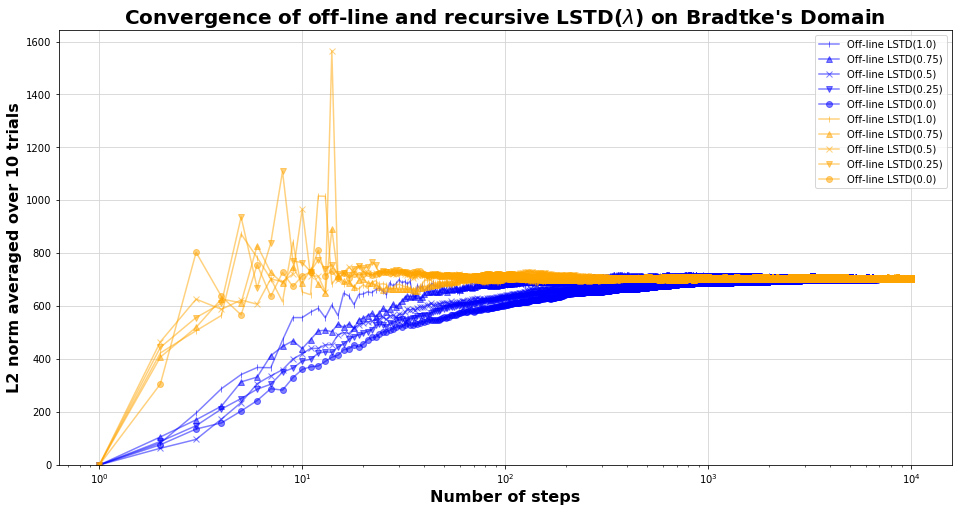

In [11]:
plt.figure(figsize=(16, 8))

# Run experiments for different lambda values for the off-line algorithm
for lamda, marker in tqdm(zip(lambdas, markers)):
    
    L2norm_offline = np.zeros(shape=(n_trials, max_steps))
    for trial in range(n_trials):
        
        # Run one experiment for n_trajectories
        betas_offline = LSTD(lambda : make_BradtkeDomain(BRADTKE_DOMAIN), bradtke_features, 0.90, lamda, n_trajectories, max_steps, return_A_b=True)
        
        # Computes RMS error of predicted values over all states
        predicted_Vs = np.dot(betas_offline, bradtke_features.T)

        # Takes the RMS error
        L2norm_offline[trial] = np.sqrt(np.mean((predicted_Vs)**2, axis=1))
        #L2norm_offline[0] = 0
    
    # Take average of RMSE over the 10 trials
    avg_L2norm_offline = np.mean(L2norm_offline, axis=0)
    avg_L2norm_offline = np.roll(avg_L2norm_offline, 2)
    avg_L2norm_offline[0] = 0; avg_L2norm_offline[1] = 0
        
    # plot results
    plt.semilogx(avg_L2norm_offline, label="Off-line LSTD({})".format(lamda), color='blue', marker=marker, alpha=0.5)

# SAME THING BUT FOR RECURSIVE ALGORITHM
for lamda, marker in tqdm(zip(lambdas, markers)):
    L2norm_recursive = np.zeros(shape=(n_trials, max_steps))
    for trial in range(n_trials):
        betas_recursive = rLSTD(lambda : make_BradtkeDomain(BRADTKE_DOMAIN), bradtke_features, 0.90, lamda, n_trajectories, max_steps, return_A_b=True)
        predicted_Vs = np.dot(betas_recursive, bradtke_features.T)
        L2norm_recursive[trial] = np.sqrt(np.mean((predicted_Vs)**2, axis=1))
    avg_L2norm_recursive = np.mean(L2norm_recursive, axis=0)
    avg_L2norm_recursive = np.roll(avg_L2norm_recursive, 2)
    avg_L2norm_recursive[0] = 0; avg_L2norm_recursive[1] = 0
    plt.semilogx(avg_L2norm_recursive, label="Off-line LSTD({})".format(lamda), color='orange', marker=marker, alpha=0.5)

# Finalize figure
plt.title("Convergence of off-line and recursive LSTD($\lambda$) on Bradtke's Domain", fontsize=20, fontweight='bold')
plt.xlabel('Number of steps', fontsize=16, fontweight='bold')
plt.ylabel('L2 norm averaged over {0} trials'.format(n_trials), fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.ylim(bottom=0)

plt.show()

### 3. Equivalence of LSTD(1) and linear regression

In his paper, Boyan demonstrates that in the case where $\lambda=1$, the LSTD($\lambda$) algorithm produces an approximation of the value function equivalent to the one we would obtain by off-line least-square linear regression. The linear regression method here is a simple supervised approach that learns to approximate the expected return for each state from Monte-Carlo returns of sampled trajectories.

In this experiment we empirically verify this claim by numerically comparing the value function produced by those two methods.

In [6]:
def build_dataset():
    """
    Samples a single trajectory and returns a training set (states, returns) that contain (x,y) values for each timestep
    """
    game = make_BoyanChain(BOYAN_CHAIN)
    obs, reward, gamma = game.its_showtime()

    states = []
    rewards = []
    while not(game.game_over):    

        # Stores current state (because it's not terminal)
        agent_mask = np.array(obs.layers['P'])
        position = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
        state = boyan_features[position[1]]
        states.append(state)

        # Do one transition and stores the reward
        obs, reward, gamma = game.play(0)
        rewards.append(reward)

    L = len(rewards)
        
    rewards = np.array(rewards)
    returns = np.zeros_like(rewards)
    states = np.array(states)

    # Computes return for every timestep
    for t in range(L):
        returns[t] = np.sum(rewards[t:])
    
    return states, returns

#### After only one trajectory update : we obtain the same Parameter Vectors

In [29]:
np.random.seed(1234)
x, y = build_dataset()
L = x.shape[0] # The lenghth of the trajectory

A_LR = 0
b_LR = 0
for t in range(L):
    A_LR += np.outer(x[t,:], x[t,:])
    b_LR += x[t,:] * y[t]
    
A_inv = np.linalg.pinv(A_LR)
beta = np.dot(A_inv, b_LR)
print("Parameters obtained after one trajectory by supervised learning :\n\n {}\n\n\n".format(beta))

np.random.seed(1234)
betas_offline = LSTD(lambda : make_BoyanChain(BOYAN_CHAIN), boyan_features, 1., 1., 1)
print("Parameters obtained after one trajectory using LSTD(1) :\n\n {}".format(betas_offline[0]))

Parameters obtained after one trajectory by supervised learning :

 [-23.06349206 -15.95238095  -5.98412698  -0.80952381]



Parameters obtained after one trajectory using LSTD(1) :

 [-23.06349206 -15.95238095  -5.98412698  -0.80952381]


#### After covergence (here 100 trajectories) : we find the same Value Estimates

In [28]:
np.random.seed(1234)

A_LR = 0
b_LR = 0

for n in range(100):
    x, y = build_dataset()
    L = x.shape[0] # The lenghth of the trajectory
    for t in range(L):
        A_LR += np.outer(x[t,:], x[t,:])
        b_LR += x[t,:] * y[t]
    
A_inv = np.linalg.pinv(A_LR)
beta = np.dot(A_inv, b_LR)
supervised_estimates = np.dot(beta, boyan_features.T)
print("Value estimates obtained after convergence by supervised learning :\n\n {} \n\n\n".format(supervised_estimates))

np.random.seed(1234)
betas_offline = LSTD(lambda : make_BoyanChain(BOYAN_CHAIN), boyan_features, 1., 1., 100)
LSTD_estimates = np.dot(betas_offline[-1], boyan_features.T)
print("Value estimates obtained after convergence using LSTD(1) :\n\n {}".format(LSTD_estimates))

Value estimates obtained after convergence by supervised learning :

 [-24.38918943 -22.42292205 -20.45665467 -18.49038729 -16.52411991
 -14.41660413 -12.30908836 -10.20157259  -8.09405682  -6.07484016
  -4.05562349  -2.03640683   0.        ] 



Value estimates obtained after convergence using LSTD(1) :

 [-24.38918943 -22.42292205 -20.45665467 -18.49038729 -16.52411991
 -14.41660413 -12.30908836 -10.20157259  -8.09405682  -6.07484016
  -4.05562349  -2.03640683   0.        ]


# Discussion

For the Boyan's Chain environment, we face an episodic task so we set $\gamma = 1$ and try out different values of $\lambda$. Our experiments showed good convergence for every value of $\lambda$ between 0 and 1, and we run each experiment for 1000 trajectories. We plot the RMS error between the value estimates found by the algorithm after each trajectory and the true value estimates computed using the optimal parameters. We can see that both Off-line and Recursive LSTD($\lambda$) fastly converge to parameters very close to the optimal ones, allowing the agent to reach very low RMS error compared to the true values of those states.

For the Bradtke's Domain environment, as it is a continuing task, we set $\gamma = 0.90$. We again try out different values of $\lambda$. As we don't have access to the optimal parameters for this task, we plot the L2 norm of the value estimates of our algorithm as a function of timestep and run it for a single trajectory of 10,000 steps (even though the algorithm only computes its parameters at the end of the trajectory, we record the intermediate matrices A and vectors b throughout the process for the purpose of being able to compute intermediate value estimates and therefore study the convergence). We can see that both algorithms quickly converge to some parameter (the L2 norm of the value estimates stabilizes). We also note instabilities over the first 20 steps for the recursive algorithm. Those **numerical instabilities** become much more problemtic for higher values of discount factor. Comparatively, the Off-line algorithm is much more stable.

Finally, we have empirically verified the proof in Appendix of Boyan's paper that claims that in the case where $\lambda=1$, the LSTD($\lambda$) algorithm produces an approximation of the value function equivalent to the one we would obtain by off-line least-square linear regression. By implementing the approach for linear regression and by comparing it to our implementation of LSTD(1) (1) the parameters obtained after a single trajectory update are identical for both methods and (2) that the solutions found to the prediction problem after convergence (here we run for 100 trajectories) are also identical for both methods. It is not surprising that the solutions found after convergence are also the same as contributions for many trajectories are simply summed into the matrix and vector A and b. Thus, demonstrating that a single trajectory update is equivalent is enough to induce that both algorithms accomplish the same effect.

# Conclusion

In this assignment, we have read papers about LSTD($\lambda$) and implemented 2 versions of this algorithm (off-line and recursive) that we have tested in two simple environments. We have seen how LSTD algorithms work, by making better use of data at the expanse of more computations. Finally, we have also empirically shown that the update made by the Off-line LSTD($\lambda$) when $\lambda=1$ is equivalent to supervised linear regression.